# Sizing for Basic (Improved) OTA With Schematic

**Copyright 2024 Harald Pretl**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0

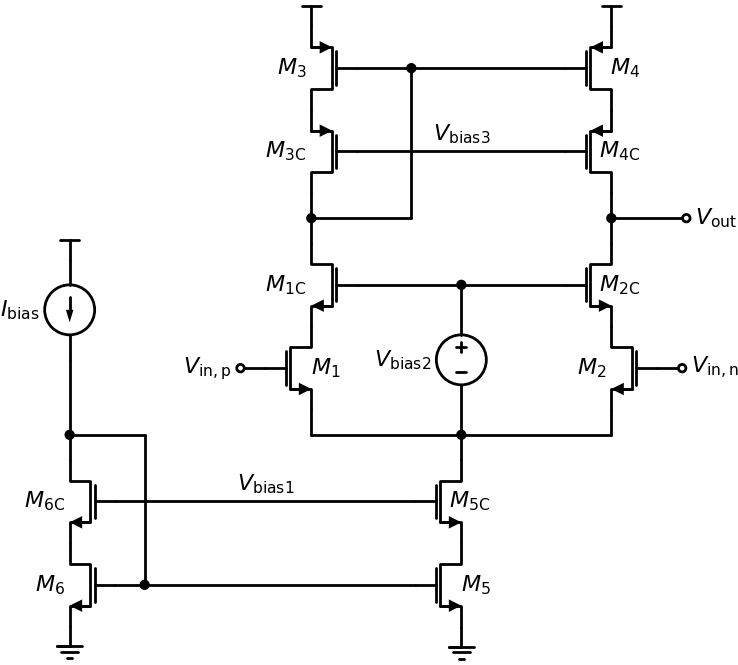

In [14]:
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=16)
    
    M1C = elm.AnalogNFet(offset_gate=False).drop('source').theta(0).label(r'$M_\mathrm{1C}$')
    M1 = elm.AnalogNFet(offset_gate=False).drop('source').theta(0).label('$M_1$', ofst=-1.5).reverse()
    elm.Line().down().length(0.5)
    elm.Line().right().length(3).dot()
    tailpoint=d.here
    d.push()

    elm.Line().down().length(0.5)
    M5C = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_\mathrm{5C}$', ofst=-1.5).reverse()
    M5 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label('$M_5$', ofst=-1.5).reverse()
    elm.Ground()
    elm.Line().left().length(6).at(M5.gate)
    M6 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label('$M_6$')
    elm.Ground()

    M6C = elm.AnalogNFet(offset_gate=False).at(M6.drain).anchor('source').theta(0).label(r'$M_\mathrm{6C}$')

    elm.Line().up().dot().at(M6C.drain).length(0.5)
    d.push()
    elm.Line().up().length(1.5)
    Ibias = elm.SourceI().up().label(r'$I_\mathrm{bias}$').reverse()
    elm.Vdd()
    d.pop()
    elm.Line().right().length(1.5)
    elm.Line().down().toy(M6.gate).dot()

    d.pop()
    elm.Line().right().length(3)
    elm.Line().up().length(0.5)
    M2 = elm.AnalogNFet(offset_gate=False).anchor('source').drop('drain').theta(0).label('$M_2$')
    M2C = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label(r'$M_\mathrm{2C}$', ofst=-1.5).reverse()
    
    elm.Line().left().at(M1.gate).length(0.5).dot(open=True).label(r'$V_\mathrm{in,p}$', 'left')
    elm.Line().right().at(M2.gate).length(0.5).dot(open=True).label(r'$V_\mathrm{in,n}$', 'right')
    
    elm.Line().up().at(M1C.drain).length(0.5).dot()
    d.push()
    elm.Line().up().length(0.5)
    M3C = elm.AnalogPFet(offset_gate=False).anchor('drain').drop('source').theta(0).label(r'$M_\mathrm{3C}$')
    M3 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label('$M_3$')
    elm.Vdd().at(M3.source)

    elm.Line().up().at(M2C.drain).length(0.5).dot()
    d.push()
    elm.Line().right().length(1.5).dot(open=True).label(r'$V_\mathrm{out}$', 'right')
    d.pop()
    elm.Line().up().length(0.5)
    M4C = elm.AnalogPFet(offset_gate=False).anchor('drain').drop('source').theta(0).label(r'$M_\mathrm{4C}$', ofst=-1.5).reverse()
    M4 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label('$M_4$', ofst=-1.5).reverse()
    elm.Vdd().at(M4.source)

    elm.Line().at(M4.gate).tox(M3.gate)
    
    d.pop()
    elm.Line().right().length(2)
    elm.Line().up().toy(M3.gate).dot()

    elm.Line().at(M5C.gate).tox(M6C.gate).label(r'$V_\mathrm{bias1}$')

    elm.Line().at(M1C.gate).tox(M5C.drain).dot()
    d.push()
    elm.Line().tox(M2C.gate)
    d.pop()
    Vbias2 = elm.SourceV().down().to(tailpoint).label(r'$V_\mathrm{bias2}$').reverse()

    elm.Line().at(M3C.gate).tox(M4C.gate).label(r'$V_\mathrm{bias3}$') 

In [15]:
# read table data
from pygmid import Lookup as lk
import numpy as np
lv_nmos = lk('sg13_lv_nmos.mat')
lv_pmos = lk('sg13_lv_pmos.mat')
# list of parameters: VGS, VDS, VSB, L, W, NFING, ID, VT, GM, GMB, GDS, CGG, CGB, CGD, CGS, CDD, CSS, STH, SFL
# if not specified, minimum L, VDS=max(vgs)/2=0.9 and VSB=0 are used 

In [16]:
# define the given parameters as taken from the specification table or initial guesses
c_load = 50e-15
gm_id_m12 = 13
gm_id_m12c = 13
gm_id_m34 = 13
gm_id_m34c = 13
gm_id_m56 = 13
gm_id_m56c = 13
l_12 = 0.5
l_12c = 0.5
l_34 = 0.5
l_34c = 0.5
l_56 = 1
l_56c = 1
f_bw = 10e6
i_total_limit = 10e-6
i_bias_in = 20e-6
output_voltage = 1.3
vin_min = 0.7
vin_max = 0.9
vdd_min = 1.45
vdd_max = 1.55
vds_headroom = 0.2

In [17]:
# we get the required gm of M1/2 from the bandwidth requirement
# we add a factor of 3 to allow for PVT variation plus additional MOSFET parasitic loading
# we also add an additional factor of 2 to get more dc gain (and there is power still in the budget)
gm_m12 = f_bw * 3 * 4*np.pi*c_load * 3
print('gm12 =', round(gm_m12/1e-3, 4), 'mS')

gm12 = 0.0565 mS


In [18]:
# since we know gm12 and the gmid we can calculate the bias current
id_m12 = gm_m12 / gm_id_m12
i_total = 2*id_m12
print('i_total (exact) =', round(i_total/1e-6, 1), 'µA')
# we round to 0.5µA bias currents
i_total = max(round(i_total / 1e-6 * 2) / 2 * 1e-6, 0.5e-6)
# here is a manual override to set the current; we keep a reserve of 2µA for bias branch
i_total = 8e-6
id_m12 = i_total/2

print('i_total (rounded) =', i_total/1e-6, 'µA')
if i_total < i_total_limit:
    print('[info] power consumption target is met!')
else:
    print('[info] power consumption target is NOT met!') 

i_total (exact) = 8.7 µA
i_total (rounded) = 8.0 µA
[info] power consumption target is met!


In [19]:
# we calculate the dc gain
gm_gds_m12 = lv_nmos.lookup('GM_GDS', GM_ID=gm_id_m12, L=l_12, VDS=vds_headroom, VSB=2*vds_headroom)
gm_gds_m12c = lv_nmos.lookup('GM_GDS', GM_ID=gm_id_m12c, L=l_12c, VDS=vds_headroom, VSB=3*vds_headroom)
gm_gds_m34 = lv_pmos.lookup('GM_GDS', GM_ID=gm_id_m34, L=l_34, VDS=vds_headroom, VSB=0)
gm_gds_m34c = lv_pmos.lookup('GM_GDS', GM_ID=gm_id_m34c, L=l_34c, VDS=vds_headroom, VSB=vds_headroom)
# conductance of lower cascoded differential pair
gds_m12 = gm_m12 / gm_gds_m12
gds_m12_casc = gds_m12 / gm_gds_m12c
# conductance of upper cascoded current mirror
gm_m34 = gm_id_m34 * i_total/2
gds_m34 = gm_m34 / gm_gds_m34
gds_m34_casc = gds_m34 / gm_gds_m34c

print('gds_12 =', round(gds_m12/1e-6, 3), 'µs')
print('gm_12c/gds_12c =',round(float(gm_gds_m12c), 1))
print('gds_34 =', round(gds_m34/1e-6, 3), 'µs')
print('gm_34c/gds_34c =', round(float(gm_gds_m34c), 1))

a0 = gm_m12 / (gds_m12_casc + gds_m34_casc)
print('a0 =', round(20*np.log10(a0), 1), 'dB')

gds_12 = 4.026 µs
gm_12c/gds_12c = 13.4
gds_34 = 2.031 µs
gm_34c/gds_34c = 24.9
a0 = 43.4 dB


In [20]:
# we calculate the MOSFET capacitance which adds to Cload, to see the impact on the BW
gm_cgs_m12 = lv_nmos.lookup('GM_CGS', GM_ID=gm_id_m12, L=l_12, VDS=vds_headroom, VSB=2*vds_headroom)
gm_cdd_m12c = lv_nmos.lookup('GM_CDD', GM_ID=gm_id_m12c, L=l_12c, VDS=vds_headroom, VSB=3*vds_headroom)
gm_cdd_m34c = lv_pmos.lookup('GM_CDD', GM_ID=gm_id_m34c, L=l_34c, VDS=vds_headroom, VSB=vds_headroom)

c_load_parasitic = abs(gm_m12/gm_cgs_m12) + abs(gm_m12/gm_cdd_m12c) + abs(gm_m34/gm_cdd_m34c)
print('additional load capacitance =', round(c_load_parasitic/1e-15, 1), 'fF')

f_bw = gm_m12 / (4*np.pi * (c_load + c_load_parasitic))
print('-3dB bandwidth incl. parasitics =', round(f_bw/1e6, 2), 'MHz')

additional load capacitance = 5.5 fF
-3dB bandwidth incl. parasitics = 81.15 MHz


In [21]:
# we can now look up the VGS of the MOSFET
vgs_m12 = lv_nmos.look_upVGS(GM_ID=gm_id_m12, L=l_12, VDS=vds_headroom, VSB=2*vds_headroom)
vgs_m12c = lv_nmos.look_upVGS(GM_ID=gm_id_m12c, L=l_12c, VDS=vds_headroom, VSB=3*vds_headroom)
vgs_m34 = lv_pmos.look_upVGS(GM_ID=gm_id_m34, L=l_34, VDS=vds_headroom, VSB=0.0) 
vgs_m34c = lv_pmos.look_upVGS(GM_ID=gm_id_m34c, L=l_34c, VDS=vds_headroom, VSB=vds_headroom) 
vgs_m56 = lv_nmos.look_upVGS(GM_ID=gm_id_m56, L=l_56, VDS=vds_headroom, VSB=0.0) 
vgs_m56c = lv_nmos.look_upVGS(GM_ID=gm_id_m56c, L=l_56c, VDS=vds_headroom, VSB=vds_headroom) 

print('vgs_12  =', round(float(vgs_m12), 3), 'V')
print('vgs_12c =', round(float(vgs_m12c), 3), 'V')
print('vgs_34  =', round(float(vgs_m34), 3), 'V')
print('vgs_34c =', round(float(vgs_m34c), 3), 'V')
print('vgs_56  =', round(float(vgs_m56), 3), 'V')
print('vgs_56c =', round(float(vgs_m56c), 3), 'V')

vgs_12  = 0.436 V
vgs_12c = 0.458 V
vgs_34  = 0.475 V
vgs_34c = 0.512 V
vgs_56  = 0.358 V
vgs_56c = 0.384 V


In [22]:
# calculate settling time due to slewing with the calculated bias current
t_slew = (c_load + c_load_parasitic) * output_voltage / i_total
print('slewing time  =', round(t_slew/1e-6, 3), 'µs')
t_settle = 5/(2*np.pi*f_bw)
print('settling time =', round(t_settle/1e-6, 3), 'µs')

slewing time  = 0.009 µs
settling time = 0.01 µs


In [23]:
# calculate voltage gain error
gain_error = a0 / (1 + a0)
print('voltage gain error =', round((gain_error-1)*100, 1), '%')

voltage gain error = -0.7 %


In [24]:
# calculate total rms output noise
sth_m12 = lv_nmos.lookup('STH_GM', VGS=vgs_m12, L=l_12, VDS=vds_headroom, VSB=2*vds_headroom) * gm_m12
gamma_m12 = sth_m12/(4*1.38e-23*300*gm_m12)

sth_m34 = lv_pmos.lookup('STH_GM', VGS=vgs_m34, L=l_34, VDS=vds_headroom, VSB=0) * gm_m34
gamma_m34 = sth_m34/(4*1.38e-23*300*gm_m34)

output_noise_rms = np.sqrt(1.38e-23*300 / (c_load + c_load_parasitic) * (2*gamma_m12 + 2*gamma_m34 * gm_m34/gm_m12))
print('output noise =', round(output_noise_rms/1e-6, 1), 'µVrms')

output noise = 555.4 µVrms


In [25]:
# calculate all widths
id_w_m12 = lv_nmos.lookup('ID_W', GM_ID=gm_id_m12, L=l_12, VDS=vds_headroom, VSB=2*vds_headroom)
w_12 = id_m12 / id_w_m12
w_12_round = max(round(w_12*2)/2, 0.5)
print('M1/2  W =', round(w_12, 2), 'um, rounded W =', w_12_round, 'um')

id_m12c = id_m12
id_w_m12c = lv_nmos.lookup('ID_W', GM_ID=gm_id_m12c, L=l_12c, VDS=vds_headroom, VSB=3*vds_headroom)
w_12c = id_m12c / id_w_m12c
w_12c_round = max(round(w_12c*2)/2, 0.5)
print('M1/2c W =', round(w_12c, 2), 'um, rounded W =', w_12c_round, 'um')

id_m34 = id_m12
id_w_m34 = lv_pmos.lookup('ID_W', GM_ID=gm_id_m34, L=l_34, VDS=vds_headroom, VSB=0)
w_34 = id_m34 / id_w_m34
w_34_round = max(round(w_34*2)/2, 0.5) 
print('M3/4  W =', round(w_34, 2), 'um, rounded W =', w_34_round, 'um')

id_m34c = id_m12
id_w_m34c = lv_pmos.lookup('ID_W', GM_ID=gm_id_m34c, L=l_34c, VDS=vds_headroom, VSB=vds_headroom)
w_34c = id_m34c / id_w_m34c
w_34c_round = max(round(w_34c*2)/2, 0.5) 
print('M3/4c W =', round(w_34c, 2), 'um, rounded W =', w_34c_round, 'um')

id_w_m5 = lv_nmos.lookup('ID_W', GM_ID=gm_id_m56, L=l_56, VDS=vds_headroom, VSB=0)
w_5 = i_total / id_w_m5
w_5_round = max(round(w_5*2)/2, 0.5)
print('M5    W =', round(w_5, 2), 'um, rounded W =', w_5_round, 'um')

id_w_m5c = lv_nmos.lookup('ID_W', GM_ID=gm_id_m56c, L=l_56c, VDS=vds_headroom, VSB=vds_headroom)
w_5c = i_total / id_w_m5c
w_5c_round = max(round(w_5c*2)/2, 0.5)
print('M5c   W =', round(w_5c, 2), 'um, rounded W =', w_5c_round, 'um')

w_6 = w_5_round * i_bias_in / i_total
print('M6    W =', round(w_6, 2), 'um')

w_6c = w_5c_round * i_bias_in / i_total
print('M6c   W =', round(w_6c, 2), 'um')


M1/2  W = 0.83 um, rounded W = 1.0 um
M1/2c W = 0.8 um, rounded W = 1.0 um
M3/4  W = 3.28 um, rounded W = 3.5 um
M3/4c W = 2.99 um, rounded W = 3.0 um
M5    W = 3.05 um, rounded W = 3.0 um
M5c   W = 2.87 um, rounded W = 3.0 um
M6    W = 7.5 um
M6c   W = 7.5 um


In [26]:
# Print out final design values
print('Improved OTA dimensioning:')
print('--------------------------')
print('M1/2  W=', w_12_round, ', L=', l_12)
print('M1/2c W=', w_12c_round, ', L=', l_12c)
print('M3/4  W=', w_34_round, ', L=', l_34)
print('M3/4c W=', w_34c_round, ', L=', l_34c)
print('M5   W=', w_5_round, ', L=', l_56)
print('M5c  W=', w_5c_round, ', L=', l_56c)
print('M6   W=', round(w_6, 2), ', L=', l_56)
print('M6c  W=', round(w_6c, 2), ', L=', l_56c)
print()
print('Improved OTA performance summary:')
print('---------------------------------')
print('supply current =', round(i_total/1e-6, 1), 'µA')
print('output noise =', round(output_noise_rms/1e-6, 1), 'µVrms')
print('voltage gain error =', round((gain_error-1)*100, 1), '%')
print('-3dB bandwidth incl. parasitics =', round(f_bw/1e6, 2), 'MHz')
print('turn-on time (slewing+settling) =', round((t_slew+t_settle)/1e-6, 3), 'µs')
print()
print('Improved OTA bias point check:')
print('------------------------------')
print('headroom M1+M1c =', round(vdd_min-vgs_m34+vgs_m12-vin_max, 3), 'V')
print('headroom M4+M4c =', round(vdd_min-vin_max, 3), 'V')
print('headroom M5+M5c =', round(vin_min-vgs_m12, 3), 'V')

Improved OTA dimensioning:
--------------------------
M1/2  W= 1.0 , L= 0.5
M1/2c W= 1.0 , L= 0.5
M3/4  W= 3.5 , L= 0.5
M3/4c W= 3.0 , L= 0.5
M5   W= 3.0 , L= 1
M5c  W= 3.0 , L= 1
M6   W= 7.5 , L= 1
M6c  W= 7.5 , L= 1

Improved OTA performance summary:
---------------------------------
supply current = 8.0 µA
output noise = 555.4 µVrms
voltage gain error = -0.7 %
-3dB bandwidth incl. parasitics = 81.15 MHz
turn-on time (slewing+settling) = 0.019 µs

Improved OTA bias point check:
------------------------------
headroom M1+M1c = 0.512 V
headroom M4+M4c = 0.55 V
headroom M5+M5c = 0.264 V
